# Computing Invariant Manifolds of Equilibrium Points
In this notebook, we compute the manifolds of the L1 and L2 Lagrange points in the Sun-Jupiter System.

In [1]:
@time using ThreeBodyProblem
@time using OrdinaryDiffEq
@time using Plots
@time using LinearAlgebra

  0.301775 seconds (455.44 k allocations: 27.444 MiB, 2.66% gc time)
  8.607702 seconds (20.04 M allocations: 1.478 GiB, 5.88% gc time)
  4.790645 seconds (8.76 M allocations: 563.116 MiB, 3.43% gc time)
  0.000055 seconds (100 allocations: 7.891 KiB)


## Compute Lagrange Points
The first step is to define the system. ThreeBodyProblem.jl has built-in functions for common systems like Sun/Jupiter.

In [3]:
sys = sun_jupiter() # sun-jupiter system

System(Body(1.98847e30, 695700.0, 0.0, 0.0, "Sun", :yellow), Body(1.898187e27, 69911.0, 7.782799587829314e8, 3.74355659124e8, "Jupiter", :red), 7.782799587829314e8, 3.74355659124e8, 1.3271645321e11, 1.26690694941e8, 0.000953686364361088, 695700.0, 69911.0, 1.3271645321e11, 1.26690694941e8, 0.000953686364361088, 695700.0, 69911.0, 1.990368187e30, 7.782799587829314e8, 5.958055362400919e7, 13.06265067112951, 2.192435262277531e-7, "Sun/Jupiter")

There's even a recipe to plot the system for us!

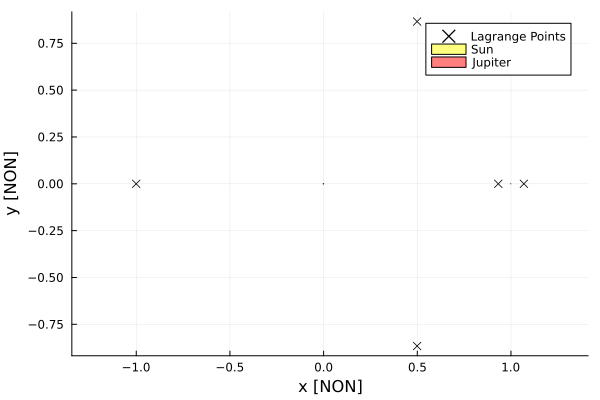

In [4]:
plot(sys) # plot the system

We can see the Lagrange Points, but where are the Sun and Jupiter? Turns out that the distance between them is so much larger than the radius of either one that it makes it hard to see them on a truly scaled picture. Let's scale the Sun and Jupiter to make them visible.

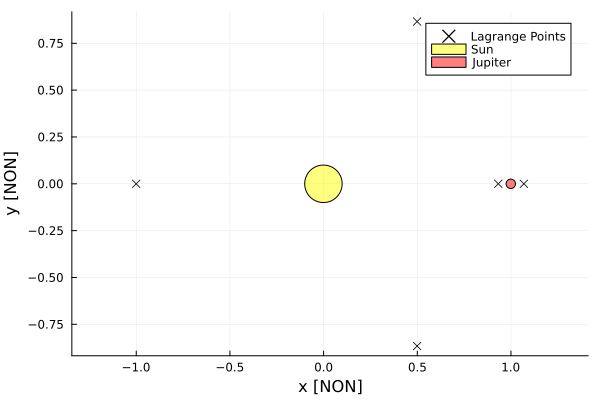

In [5]:
plot(sys, scaled = true) # scaled sun-jupiter system for better visibility

That's better.

### Now let's compute the L1 and L2 Lagrange points of our system

In [6]:
L1, L2 = computeLpts(sys) # compute the L1 and L2 Lagrange points
# Declare state vectors for L1 and L2 (with zero velocity)
rv1 = [L1; zeros(3)] # state at Lagrange point L1 (zero velocity added on)
rv2 = [L2; zeros(3)] # state at Lagrange point L2

6-element Vector{Float64}:
 1.0688260003760226
 0.0
 0.0
 0.0
 0.0
 0.0

The Lagrange points are equilibrium points in our dynamics. This means that an object placed there perfectly will stay there forever. But, Lagrange points L1, L2, and L3 are unstable, meaning if you perturb the object slightly, it may fall away. This is how we will generate the invariant manifolds.

## How to Perturb
We need to linearize the dynamics about these Lagrange points to determine which directions are stable and unstable

### State Transition Matrix (STM) and Linearized Equations of Motion
The state transition matrix $\Phi(t_2, t_1)$ maps a small change in initial conditions to a small change in final conditions
\begin{align}
\Phi(t_2, t_1) = \frac{\partial \vec{x}(t_2)}{\partial \vec{x}(t_1)}.
\end{align}

For equations of motion $\dot{\vec{x}} = f(\vec{x})$, the STM evolves according to the variational equations
\begin{align}
\dot{\Phi} = \frac{\partial f}{\partial \vec{x}}\Phi
\end{align}

The ```CR3BPstm()``` function computes $\frac{\partial f}{\partial \vec{x}}$ for us. We just feed it the state of our Lagrange point and an identity matrix as an augmented state.

In [99]:
Φ₀ = I(6) # The initial State Transition Matrix (STM)
w₀ = vcat(rv1,reshape(Φ₀,36,1)); # Augmented state with state and STM
ẇ = CR3BPstm(w₀, sys, 0) # time derivative of augmented state
∂f_∂x = reshape(ẇ[7:42],6,6) # time derivative of STM, which is ∂f/∂x since Φ₀ = I(6)

6×6 Matrix{Float64}:
 0.0       0.0       0.0       1.0  0.0  0.0
 0.0       0.0       0.0       0.0  1.0  0.0
 0.0       0.0       0.0       0.0  0.0  1.0
 9.89225   0.0       0.0       0.0  2.0  0.0
 0.0      -3.44613   0.0      -2.0  0.0  0.0
 0.0       0.0      -4.44613   0.0  0.0  0.0

### Compute Eigenvalues and Eigenvectors of ∂f/∂x
Since the L1 and L2 points are saddle points, there should be a stable and unstable eigenvalue and corresponding eigenvectors.

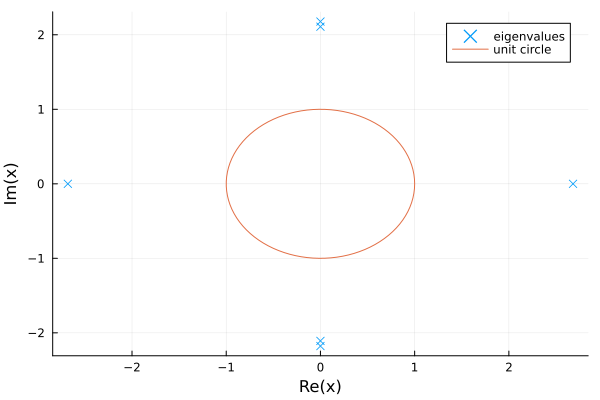

In [107]:
Λ,V = eigen(∂f_∂x,sortby=isreal) # Λ is vector of eigenvalues, V is matrix of eigenvectors
p_eig = scatter(Λ,marker=:x, label="eigenvalues");
plot!(p_eig, circle(), label="unit circle");
display(p_eig)

We see two eigenvalues on the real axis and the other four on the imaginary axis. The positive real eigenvalue corresponds to unstable motion while the negative real eigenvalue corresponds to stable motion. The others correspond to oscillatory motion.

In [98]:
Yw = real(V[:,findall(isreal, Λ)]) # Eigenvectors corresponding to real eigenvalues
Λ = Λ[findall(isreal, Λ)] # Purely real eigenvalues (have 0.0 imaginary component)
Yws = Yw[:,findmin(real(Λ))[2]] # Eigenvector associated with stable eigenvalue λ < 1
Ywu = Yw[:,findmax(real(Λ))[2]] # Eigenvector associated with unstable eigenvalue λ > 1

6-element Vector{Float64}:
 -0.3120381576020455
  0.15733853966087671
 -6.830185745899216e-20
 -0.8366144216015705
  0.421844855018967
  0.0

Yws is the eigenvector of the stable eigenvalue, while Ywu is the eigenvector of the unstable eigenvalue.

## Perturb in the Stable and Unstable Directions
If we perturb our initial state in these directions and integrate, we will have approximated the stable and unstable manifolds.

In [109]:
α = 1e-6 # perturbation magnitude

# L1 points
rv1up = rv1 + α*Ywu/norm(Ywu) # unstable manifold positive side
rv1un = rv1 - α*Ywu/norm(Ywu) # unstable manifold negative side
rv1sp = rv1 + α*Yws/norm(Yws) # stable manifold positive side
rv1sn = rv1 - α*Yws/norm(Yws); # stable manifold negative side

### Integrate Forward and Backward in Time
The unstable manifold will fall away as time progresses, so we integrate rv1up and rv2un forward in time. The stable manifold will cling to the Lagrange point as time progresses but will fall away as time moves back, so we integrate rv1sp and rv2sp backward in time.

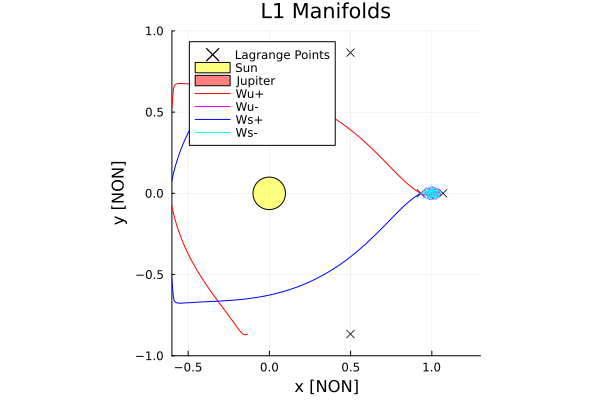

In [113]:
# Integrate trajectories for 2 Jupiter periods
tf = 2*2π
tspan_forward = (0.,tf) # make sure to add decimal points so tspan contains floating point values, not integers
tspan_back = (0.,-tf)
myreltol = 1e-12

# Set up the ODE Problems
prob1up = ODEProblem(CR3BPdynamics!,rv1up,tspan_forward,sys) # Unstable positive
prob1un = ODEProblem(CR3BPdynamics!,rv1un,tspan_forward,sys) # Unstable negative
prob1sp = ODEProblem(CR3BPdynamics!,rv1sp,tspan_back,sys) # Stable positive
prob1sn = ODEProblem(CR3BPdynamics!,rv1sn,tspan_back,sys) # Stable negative

# Solutions to the ODEs
sol1up = solve(prob1up, TsitPap8(), reltol=myreltol)
sol1un = solve(prob1un, TsitPap8(), reltol=myreltol)
sol1sp = solve(prob1sp, TsitPap8(), reltol=myreltol)
sol1sn = solve(prob1sn, TsitPap8(), reltol=myreltol)

plot(sys,scaled=true)
plot!(sol1up,idxs=(1,2),label="Wu+",linecolor=:red)
plot!(sol1un,idxs=(1,2),label="Wu-",linecolor=:magenta)
plot!(sol1sp,idxs=(1,2),label="Ws+",linecolor=:blue)
plot!(sol1sn,idxs=(1,2),label="Ws-",linecolor=:cyan)
plot!(aspect_ratio=1,ylims=[-1,1],xlims=[-0.6,1.3],legend=:topleft,flip=false,title="L1 Manifolds")

We can see two strands moving in towards the sun, but the rest is a jumbled mess. Let's zoom in to see what's going on. Also, we need to make sure things are scaled correctly, or Jupiter will look way too big.

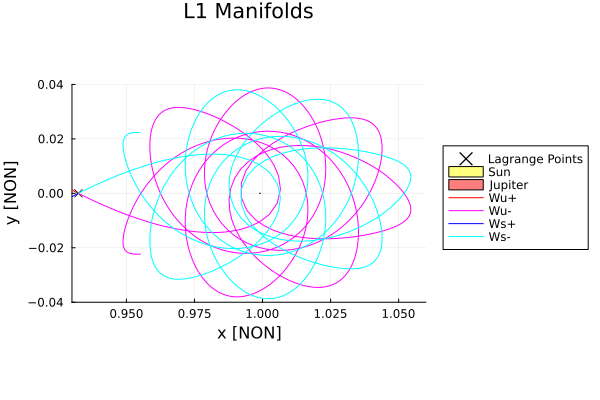

In [114]:
plot(sys)
plot!(sol1up,idxs=(1,2),label="Wu+",linecolor=:red)
plot!(sol1un,idxs=(1,2),label="Wu-",linecolor=:magenta)
plot!(sol1sp,idxs=(1,2),label="Ws+",linecolor=:blue)
plot!(sol1sn,idxs=(1,2),label="Ws-",linecolor=:cyan)
plot!(aspect_ratio=1,ylims=[-0.04,0.04],xlims=[0.93,1.06],legend=:outerright,flip=false,title="L1 Manifolds")

### Repeat for L2

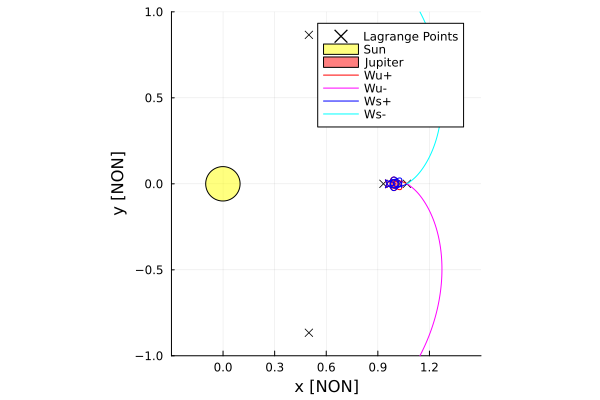

In [115]:
# L2 points
rv2up = rv2 + α*Ywu/norm(Ywu) # unstable manifold + side
rv2un = rv2 - α*Ywu/norm(Ywu) # unstable manifold - side
rv2sp = rv2 + α*Yws/norm(Yws) # stable manifold + side
rv2sn = rv2 - α*Yws/norm(Yws) # stable manifold - side

## Now we look at the L2 point manifolds
prob2up = ODEProblem(CR3BPdynamics!,rv2up,tspan_forward,sys) # Unstable positive
prob2un = ODEProblem(CR3BPdynamics!,rv2un,tspan_forward,sys) # Unstable negative
prob2sp = ODEProblem(CR3BPdynamics!,rv2sp,tspan_back,sys) # Stable positive
prob2sn = ODEProblem(CR3BPdynamics!,rv2sn,tspan_back,sys) # Stable negative

sol2up = solve(prob2up, TsitPap8(), reltol=1e-6)
sol2un = solve(prob2un, TsitPap8(), reltol=1e-6)
sol2sp = solve(prob2sp, TsitPap8(), reltol=1e-6)
sol2sn = solve(prob2sn, TsitPap8(), reltol=1e-6)

plot(sys, scaled=true)
plot!(sol2up,idxs=(1,2),label="Wu+",linecolor=:red)
plot!(sol2un,idxs=(1,2),label="Wu-",linecolor=:magenta)
plot!(sol2sp,idxs=(1,2),label="Ws+",linecolor=:blue)
plot!(sol2sn,idxs=(1,2),label="Ws-",linecolor=:cyan)
plot!(aspect_ratio=1,ylims=[-1.0,1.0],xlims=[-0.3,1.5],legend=:topright,flip=false)

This time there are two strands moving out away from the Sun, along with another jumble around Jupiter. Let's zoom in again to take a look.

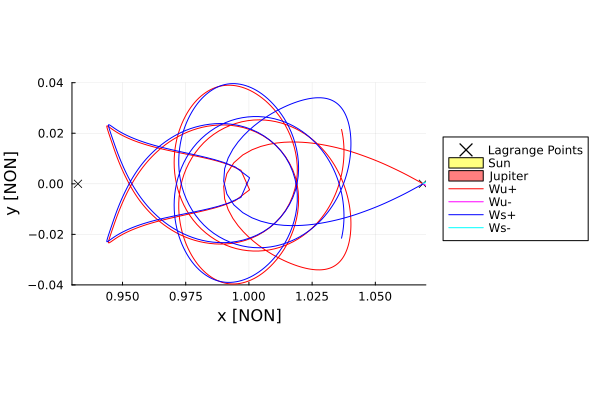

In [116]:
plot(sys)
plot!(sol2up,idxs=(1,2),label="Wu+",linecolor=:red)
plot!(sol2un,idxs=(1,2),label="Wu-",linecolor=:magenta)
plot!(sol2sp,idxs=(1,2),label="Ws+",linecolor=:blue)
plot!(sol2sn,idxs=(1,2),label="Ws-",linecolor=:cyan)
plot!(aspect_ratio=1,ylims=[-0.04,0.04],xlims=[0.93,1.07],legend=:outerright,flip=false)